In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_ = 0.0005

def train(model, device, train_loader, optimizer, epoch, choice):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # L1 Regulizer for choice = 3    
    if(choice == 3):
        l1_reg = None
        for w in model.parameters():
            if l1_reg is None:
                l1_reg = w.abs().sum()
            else:
                l1_reg = l1_reg + w.abs().sum()
            
        loss += lambda_*l1_reg
   
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
# Take user input

print("ENTER CHOICE OF NORM : 1. Layer Normalization 2. Group Normalization 3. Batch Normalization with L1 Regularization")
choice = int(input())
print("YOU HAVE ENTERED : ",choice)

ENTER CHOICE OF NORM : 1. Layer Normalization 2. Group Normalization 3. Batch Normalization with L1 Regularization
1
YOU HAVE ENTERED :  1


In [7]:
from torch.optim.lr_scheduler import StepLR
from model import getModel

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = getModel(choice)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#scheduler = StepLR(optimizer, step_size=6, gamma=0.00001)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, choice)    
    #scheduler.step()
    test(model, device, test_loader)

cuda
EPOCH: 0


Loss=0.07742498070001602 Batch_id=937 Accuracy=93.93: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0668, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.03923846781253815 Batch_id=937 Accuracy=97.64: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0588, Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.01541215181350708 Batch_id=937 Accuracy=98.17: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0387, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.03146515041589737 Batch_id=937 Accuracy=98.38: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.20334821939468384 Batch_id=937 Accuracy=98.58: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0279, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.16216407716274261 Batch_id=937 Accuracy=98.67: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0285, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.00757443904876709 Batch_id=937 Accuracy=98.82: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.08612985908985138 Batch_id=937 Accuracy=98.89: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0223, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.024781018495559692 Batch_id=937 Accuracy=98.95: 100%|█| 938/938 [00:



Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.039108842611312866 Batch_id=937 Accuracy=99.01: 100%|█| 938/938 [00:



Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.06854304671287537 Batch_id=937 Accuracy=99.07: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.1253158450126648 Batch_id=937 Accuracy=99.09: 100%|█| 938/938 [00:08



Test set: Average loss: 0.0208, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.007016569375991821 Batch_id=937 Accuracy=99.11: 100%|█| 938/938 [00:



Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.2546672523021698 Batch_id=937 Accuracy=99.12: 100%|█| 938/938 [00:08



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.06799750030040741 Batch_id=937 Accuracy=99.24: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.06545540690422058 Batch_id=937 Accuracy=99.23: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0227, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.066628098487854 Batch_id=937 Accuracy=99.24: 100%|█| 938/938 [00:09<



Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.012614808976650238 Batch_id=937 Accuracy=99.30: 100%|█| 938/938 [00:



Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.02131609618663788 Batch_id=937 Accuracy=99.28: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.01001499593257904 Batch_id=937 Accuracy=99.38: 100%|█| 938/938 [00:0



Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

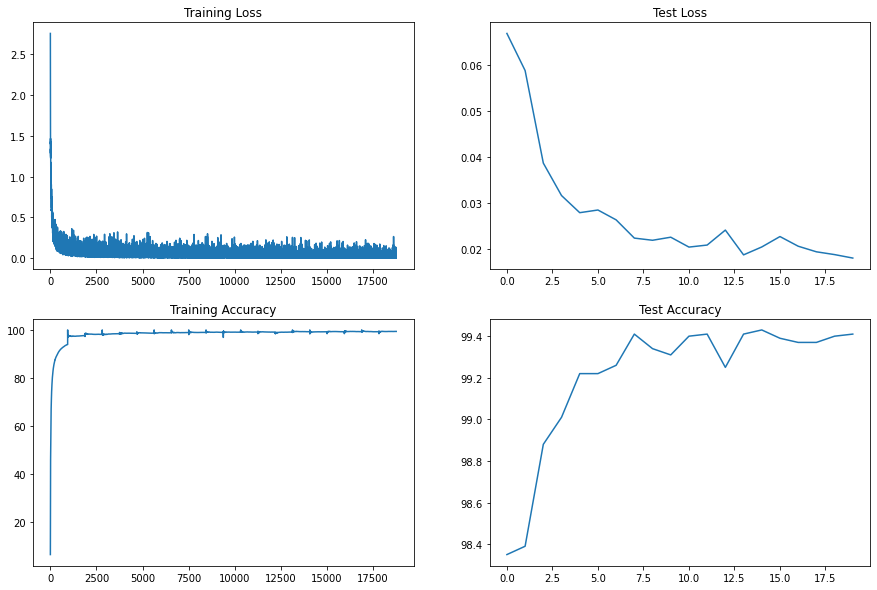

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

train_losses_cpu = []
for loss in train_losses:
    train_losses_cpu.append(loss.cpu().data.numpy())  

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")